# Model exploration

## Introduction

This notebook is used to explore the different models that we will use to predict if the player is worth inveting in. We will use the same data cleaning and feature selecting as the one found in the notebook `data_preprocessing.ipynb`. We will then search for the best hyperparameters for one ore two selected models. We might explore to put some threashold on the predicted values probabilities to adjust the prediction to better fit our metrics. As we disccused in the `data_preprocessing.ipynb` notebook, we will use first f1 score to evaluate our models. We will have alook at the recalls as well as we don't want to miss too much players. We will then select the best model and save it to use it in the API.

In [141]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

pd.set_option('display.max_column', None)

data_path = './../data/nba_logreg.csv'
df = pd.read_csv(data_path)

FOLDS = 3

## Functions to preprocess and evaluate the data

In [142]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE, RandomOverSampler

def preprocessing(data, method=None):
    """
    Preprocessing data

    Parameters
    ----------
    data : pandas.DataFrame
        Data to be preprocessed
    method : str
        Method to be used for balancing data, default None
    """
    data = data.drop(['Name'], axis=1)
    data.loc[:, '3P%'] = data.loc[:, '3P%'].fillna(0)
    data = data.drop_duplicates()
    
    if method == 'oversample':
        ros = RandomOverSampler(random_state=0)
        X = data.drop('TARGET_5Yrs', axis=1)
        y = data['TARGET_5Yrs']
        X_resampled, y_resampled = ros.fit_resample(X, y)
        data = pd.concat([X_resampled, y_resampled], axis=1)
    elif method == 'undersample':
        rus = RandomUnderSampler(random_state=0)
        X = data.drop('TARGET_5Yrs', axis=1)
        y = data['TARGET_5Yrs']
        X_resampled, y_resampled = rus.fit_resample(X, y)
        data = pd.concat([X_resampled, y_resampled], axis=1).reset_index(drop=True)
    elif method == 'smote':
        sm = SMOTE(random_state=0)
        X = data.drop('TARGET_5Yrs', axis=1)
        y = data['TARGET_5Yrs']
        X_resampled, y_resampled = sm.fit_resample(X, y)
        data = pd.concat([X_resampled, y_resampled], axis=1)
    
    return data

In [143]:
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.model_selection import KFold

def score_classifier(dataset,classifier,labels, folds=FOLDS, verbose=True, threshold_func=None):
    
    """
    This function takes in a dataset, classifier and labels and returns the mean confusion matrix, recall, precision, accuracy and f1 score
    for the classifier using KFold cross validation with the number of folds specified by the user

    Parameters:
    dataset: pandas dataframe
    classifier: sklearn classifier
    labels: pandas series
    folds: int

    Returns:
    dict: dictionary containing mean confusion matrix, recall, precision, accuracy and f1 score
    """

    kf = KFold(n_splits=folds,random_state=50,shuffle=True)
    confusion_mat_list = []
    recall_list = []
    precision_list = []
    accuracy_list = []
    f1_list = []

    for training_ids,test_ids in kf.split(dataset):
        training_set = dataset.iloc[training_ids]
        training_labels = labels.iloc[training_ids]
        test_set = dataset.iloc[test_ids]
        test_labels = labels.iloc[test_ids]
        classifier.fit(training_set,training_labels)

        if threshold_func:
            predicted_labels = threshold_func(classifier, test_set)

        else:
            predicted_labels = classifier.predict(test_set)

        confusion_mat = confusion_matrix(test_labels,predicted_labels)
        recall = recall_score(test_labels, predicted_labels)
        precision = precision_score(test_labels, predicted_labels)
        accuracy = classifier.score(test_set, test_labels)
        f1 = 2 * (precision * recall) / (precision + recall)

        recall_list.append(recall)
        precision_list.append(precision)
        accuracy_list.append(accuracy)
        f1_list.append(f1)
        confusion_mat_list.append(confusion_mat)

    recall = np.mean(recall_list)
    precision = np.mean(precision_list)
    accuracy = np.mean(accuracy_list)
    f1 = np.mean(f1_list)
    confusion_mat = np.mean(confusion_mat_list,axis=0).astype(int)
    confusion_mat_df = pd.DataFrame(confusion_mat,columns=['Predicted 0','Predicted 1'],index=['Actual 0','Actual 1'])

    if verbose:
        print(f"confusion_mat: \n {confusion_mat_df}")
        print(f"recall:{recall}")
        print(f"precision:{precision}")
        print(f"accuracy:{accuracy}")
        print(f"f1:{f1}")
    return {'confusion_mat':confusion_mat,'recall':recall,'precision':precision,'accuracy':accuracy,'f1':f1, 'classifier':classifier}


## First score

Have a look at the score that we obtain if we apply the process of the test.py file to the data. We will use the same process to evaluate the models.

In [140]:
# first scores

from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

df_test = df.copy()
X = df_test.drop(['TARGET_5Yrs', 'Name'], axis=1)
y = df_test['TARGET_5Yrs']

# fill nan
X.loc[:, '3P%'] = X.loc[:, '3P%'].fillna(0)

pipeline = Pipeline(steps=[('scaler', MinMaxScaler()), ('classifier', SVC())])

scores = score_classifier(X, pipeline, y)


confusion_mat: 
           Predicted 0  Predicted 1
Actual 0           88           81
Actual 1           49          227
recall:0.82197349073024
precision:0.737884007009773
accuracy:0.7082142033085542
f1:0.7774117527708234


The f1 score and recall are already quite good. We will try to see if we can improve them. We had a better f1 score with the logistc regression model. Let's try other models to see if it improves.

## Models search

Let's first try a banch of different models to see which one is the best. we will standardize the data for each model has some of them are sensitive to the scale of the data.

In [144]:
# model search

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

from sklearn.pipeline import Pipeline

target = 'TARGET_5Yrs'
balance_method = None

data_processed = preprocessing(df, balance_method)
models = [LogisticRegression(), RandomForestClassifier(), SVC(), GradientBoostingClassifier(), KNeighborsClassifier(), DecisionTreeClassifier(), AdaBoostClassifier(), XGBClassifier()]
model_names = ['LogisticRegression', 'RandomForestClassifier', 'SVC', 'GradientBoostingClassifier', 'KNeighborsClassifier', 'DecisionTreeClassifier', 'AdaBoostClassifier', 'XGBClassifier']

results = []

for model, model_name in zip(models, model_names):
    pipeline = Pipeline(steps=[('scaler', StandardScaler()), ('model', model)])
    result = score_classifier(data_processed.drop(target, axis=1), pipeline, data_processed[target], verbose=False)
    result['model_name'] = model_name
    results.append(result)

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='f1', ascending=False)
results_df = results_df.reset_index(drop=True)
results_df

,confusion_mat,recall,precision,accuracy,f1,classifier,model_name
0,"[[91, 77], [45, 229]]",0.835538,0.748499,0.724392,0.789615,"(StandardScaler(), SVC())",SVC
1,"[[89, 79], [50, 224]]",0.816507,0.739207,0.707830,0.775895,"(StandardScaler(), LogisticRegression())",LogisticRegression
2,"[[92, 76], [57, 217]]",0.791978,0.740839,0.699544,0.765499,"(StandardScaler(), (DecisionTreeClassifier(max...",RandomForestClassifier
3,"[[88, 80], [57, 217]]",0.791079,0.730573,0.689749,0.759556,"(StandardScaler(), ([DecisionTreeRegressor(cri...",GradientBoostingClassifier
4,"[[85, 82], [60, 214]]",0.779440,0.722338,0.676968,0.749539,"(StandardScaler(), KNeighborsClassifier())",KNeighborsClassifier
5,"[[86, 81], [63, 211]]",0.769632,0.720752,0.673166,0.744344,"(StandardScaler(), XGBClassifier(base_score=No...",XGBClassifier
6,"[[90, 78], [67, 207]]",0.754728,0.726456,0.671684,0.740181,"(StandardScaler(), (DecisionTreeClassifier(max...",AdaBoostClassifier
7,"[[80, 87], [88, 186]]",0.680233,0.680316,0.603165,0.679910,"(StandardScaler(), DecisionTreeClassifier())",DecisionTreeClassifier


We observe that SVC has the best results among all the models that we tested. The standart scaler seems to have decrease the performance of the logistic regression model. Let's to use only the features that we selected in the notebook.

In [146]:
# model search - feature selection

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

from sklearn.pipeline import Pipeline

target = 'TARGET_5Yrs'
balance_method = None
features_selected = ['GP', 'PTS', 'FGM', 'MIN', 'FGA', 'DREB', 'BLK', 'AST']

data_processed = preprocessing(df, balance_method)
X = data_processed[features_selected]
y = data_processed[target]

models = [LogisticRegression(), RandomForestClassifier(), SVC(), GradientBoostingClassifier(), KNeighborsClassifier(), DecisionTreeClassifier(), AdaBoostClassifier(), XGBClassifier()]
model_names = ['LogisticRegression', 'RandomForestClassifier', 'SVC', 'GradientBoostingClassifier', 'KNeighborsClassifier', 'DecisionTreeClassifier', 'AdaBoostClassifier', 'XGBClassifier']

results = []

for model, model_name in zip(models, model_names):
    pipeline = Pipeline(steps=[('scaler', StandardScaler()), ('model', model)])
    result = score_classifier(X, pipeline, y, folds=4, verbose=False)
    result['model_name'] = model_name
    results.append(result)

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='f1', ascending=False)
results_df = results_df.reset_index(drop=True)
results_df

,confusion_mat,recall,precision,accuracy,f1,classifier,model_name
0,"[[65, 61], [38, 167]]",0.811455,0.732880,0.699548,0.769699,"(StandardScaler(), ([DecisionTreeRegressor(cri...",GradientBoostingClassifier
1,"[[68, 57], [41, 164]]",0.797009,0.741826,0.701807,0.768044,"(StandardScaler(), SVC())",SVC
2,"[[65, 60], [40, 165]]",0.802811,0.733200,0.696536,0.765921,"(StandardScaler(), LogisticRegression())",LogisticRegression
3,"[[64, 61], [45, 161]]",0.781418,0.723157,0.678464,0.750508,"(StandardScaler(), (DecisionTreeClassifier(max...",RandomForestClassifier
4,"[[68, 57], [49, 157]]",0.762112,0.731604,0.678464,0.746257,"(StandardScaler(), (DecisionTreeClassifier(max...",AdaBoostClassifier
5,"[[62, 63], [46, 159]]",0.772423,0.714348,0.667922,0.741932,"(StandardScaler(), KNeighborsClassifier())",KNeighborsClassifier
6,"[[65, 61], [51, 155]]",0.751639,0.716377,0.662651,0.732907,"(StandardScaler(), XGBClassifier(base_score=No...",XGBClassifier
7,"[[62, 64], [67, 138]]",0.670609,0.683103,0.603163,0.676626,"(StandardScaler(), DecisionTreeClassifier())",DecisionTreeClassifier


We observe a decrease of performance for the best models. Let's try to remove the satndart scaler for logistic though it seems to have a better performance without it.

In [147]:
# model search - feature selection

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

from sklearn.pipeline import Pipeline

target = 'TARGET_5Yrs'
balance_method = None
features_selected = ['GP', 'PTS', 'FGM', 'MIN', 'FGA', 'DREB', 'BLK', 'AST']

data_processed = preprocessing(df, balance_method)
X = data_processed[features_selected]
y = data_processed[target]

lr = Pipeline(steps=[('model', LogisticRegression(C=0.1, solver='liblinear'))])
svc = Pipeline(steps=[('scaler', StandardScaler()), ('model', SVC())])

models = [lr, svc]
model_names = ['LogisticRegression', 'SVC']

results = []

for model, model_name in zip(models, model_names):
    result = score_classifier(X, model, y, folds=5, verbose=False)
    result['model_name'] = model_name
    results.append(result)

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='f1', ascending=False)
results_df = results_df.reset_index(drop=True)
results_df

,confusion_mat,recall,precision,accuracy,f1,classifier,model_name
0,"[[44, 56], [21, 143]]",0.868543,0.718817,0.707820,0.786000,"(LogisticRegression(C=0.1, solver='liblinear'))",LogisticRegression
1,"[[54, 46], [33, 131]]",0.797929,0.741074,0.701793,0.767685,"(StandardScaler(), SVC())",SVC


We observe that the logistic regression model has the best performance if we remove the standart scaler for it. Let's try to tune the hyperparameters of this model to see if we can improve the performance. However let's remind that SVC had better performances on all features selected.

## Hyperparameters tuning

Let's first try on the logistic regression model. let's add an autolmatic selection of the best features with ANOVA test, polynomial features, search for the best C (inverse of the regularization strength) and the best solver.

In [150]:
from sklearn.model_selection import RandomizedSearchCV

target = 'TARGET_5Yrs'
balance_method = None

data_processed = preprocessing(df, balance_method)
X = data_processed.drop(target, axis=1)
y = data_processed[target]

pipeline = Pipeline(steps=[
    ('polynomial_features', PolynomialFeatures(2, include_bias=False)), 
    ('select_k_best', SelectKBest(f_classif, k=10)), 
    ('model', LogisticRegression())])

param_grid = {'polynomial_features__degree': range(1, 5),
                'select_k_best__k': range(1, 19),
                'model__C': [0.01, 0.1, 1, 10],
                'model__solver': ['liblinear', 'lbfgs', 'saga']}

random_search = RandomizedSearchCV(pipeline, param_grid, cv=FOLDS, scoring='f1', n_jobs=-1, verbose=1, n_iter=200)
random_search.fit(X, y)

print(random_search.best_params_)

Fitting 3 folds for each of 200 candidates, totalling 600 fits


{'select_k_best__k': 1, 'polynomial_features__degree': 2, 'model__solver': 'liblinear', 'model__C': 0.1}


Let's try again to improve C.

In [52]:
from sklearn.model_selection import RandomizedSearchCV

target = 'TARGET_5Yrs'
balance_method = None

data_processed = preprocessing(df, balance_method)
X = data_processed.drop(target, axis=1)
y = data_processed[target]

pipeline = Pipeline(steps=[
    ('polynomial_features', PolynomialFeatures(2, include_bias=False)), 
    ('select_k_best', SelectKBest(f_classif, k=10)), 
    ('model', LogisticRegression())])

param_grid = {'polynomial_features__degree': range(1, 3),
                'select_k_best__k': range(1, 19),
                'model__C': [0.08, 0.1, 0.12],
                'model__solver': ['liblinear']}

random_search = RandomizedSearchCV(pipeline, param_grid, cv=FOLDS, scoring='f1', n_jobs=-1, verbose=1, n_iter=100)
random_search.fit(X, y)

print(random_search.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
{'select_k_best__k': 9, 'polynomial_features__degree': 1, 'model__solver': 'liblinear', 'model__C': 0.12}


Let's evaluate the model with the best parameters.

In [151]:
target = 'TARGET_5Yrs'
balance_method = None

data_processed = preprocessing(df, balance_method)
X = data_processed.drop(target, axis=1)
y = data_processed[target]

pipeline = Pipeline(steps=[
    ('polynomial_features', PolynomialFeatures(1, include_bias=False)), 
    ('select_k_best', SelectKBest(f_classif, k=9)), 
    ('model', LogisticRegression(C=0.1, solver='liblinear'))])

result = score_classifier(X, pipeline, y, verbose=False)
result['model_name'] = 'LogisticRegression'

result

{'confusion_mat': array([[ 71,  96],
        [ 35, 239]]),
 'recall': 0.8723709144572455,
 'precision': 0.7124296091363803,
 'accuracy': 0.7025525264802918,
 'f1': 0.7840881460310399,
 'classifier': Pipeline(steps=[('polynomial_features',
                  PolynomialFeatures(degree=1, include_bias=False)),
                 ('select_k_best', SelectKBest(k=9)),
                 ('model', LogisticRegression(C=0.1, solver='liblinear'))]),
 'model_name': 'LogisticRegression'}

We observe that the model has a little bit less good performance than the one with the features that we selected. We will keep in mind the other hyperparameters though. Let's try to tune the SVC model.

In [109]:
from sklearn.model_selection import RandomizedSearchCV

target = 'TARGET_5Yrs'
balance_method = None

data_processed = preprocessing(df, balance_method)
X = data_processed.drop(target, axis=1)
y = data_processed[target]

pipeline = Pipeline(steps=[
    ('polynomial_features', PolynomialFeatures(2, include_bias=False)), 
    ('select_k_best', SelectKBest(f_classif, k=10)),
    ('scaler', StandardScaler()), 
    ('model', SVC())])

param_grid = {'polynomial_features__degree': range(1, 3),
                'select_k_best__k': range(1, 19),
                'model__C': [0.01, 0.1, 1, 10, 100, 1000],
                'model__kernel': ['rbf'],
                'model__gamma': ['scale']}


random_search = RandomizedSearchCV(pipeline, param_grid, scoring='f1', n_jobs=-1, verbose=1, n_iter=100)
random_search.fit(X, y)

print(random_search.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


{'select_k_best__k': 15, 'polynomial_features__degree': 2, 'model__kernel': 'rbf', 'model__gamma': 'scale', 'model__C': 0.1}


Let's see how it scores.

In [152]:
target = 'TARGET_5Yrs'
balance_method = None

data_processed = preprocessing(df, balance_method)
X = data_processed.drop(target, axis=1)
y = data_processed[target]

pipeline = Pipeline(steps=[
    ('polynomial_features', PolynomialFeatures(2, include_bias=False)), 
    ('select_k_best', SelectKBest(f_classif, k=15)), 
    ('scaler', StandardScaler()), 
    ('model', SVC(C=1, kernel='rbf', gamma='scale'))])

result = score_classifier(X, pipeline, y, verbose=False)
result['model_name'] = 'SVC'

result

{'confusion_mat': array([[ 90,  78],
        [ 51, 223]]),
 'recall': 0.8126427529305227,
 'precision': 0.7405975472626326,
 'accuracy': 0.707819644614227,
 'f1': 0.7749333008533599,
 'classifier': Pipeline(steps=[('polynomial_features', PolynomialFeatures(include_bias=False)),
                 ('select_k_best', SelectKBest(k=15)),
                 ('scaler', StandardScaler()), ('model', SVC(C=1))]),
 'model_name': 'SVC'}

We observe a slight loss of performance compare to the logistic regression model. However let's remind that we had a good performance with all parameters selected and that the Random search doesn't search in the full space since it's very big. Let's try to see of we can defind a threashold to improve the F1 score on the logistic regression model.

In [153]:
target = 'TARGET_5Yrs'
balance_method = None

data_processed = preprocessing(df, balance_method)
X = data_processed.drop(target, axis=1)
y = data_processed[target]

pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('model', SVC())])

result = score_classifier(X, pipeline, y,  verbose=False)
result['model_name'] = 'SVC'

result

{'confusion_mat': array([[ 91,  77],
        [ 45, 229]]),
 'recall': 0.8355377236672202,
 'precision': 0.7484986583459343,
 'accuracy': 0.7243921704816673,
 'f1': 0.7896149633515948,
 'classifier': Pipeline(steps=[('scaler', StandardScaler()), ('model', SVC())]),
 'model_name': 'SVC'}

Let's tune the threashold for the logistic regression model.

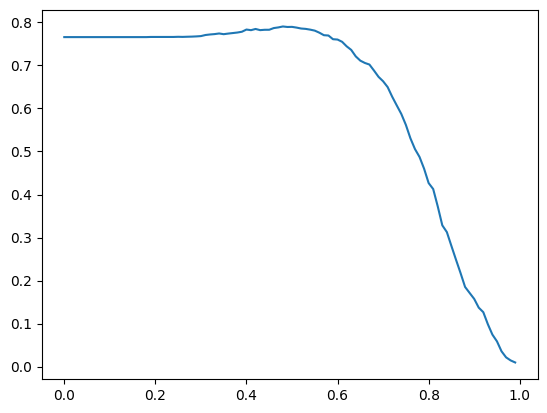

0.48

In [156]:
from sklearn.metrics import f1_score
target = 'TARGET_5Yrs'
balance_method = None
features_selected = ['GP', 'PTS', 'FGM', 'MIN', 'FGA', 'DREB', 'BLK', 'AST']

data_processed = preprocessing(df, balance_method)
X = data_processed[features_selected]
y = data_processed[target]

lr = Pipeline(steps=[('model', LogisticRegression(C=0.1, solver='liblinear'))])

result = score_classifier(X, lr, y, verbose=False)
probabilities = lr.predict_proba(X)

thresholds = np.arange(0, 1, 0.01)
scores = []
for threshold in thresholds:
    predictions = probabilities[:, 1] > threshold
    scores.append(f1_score(y, predictions))

plt.plot(thresholds, scores)
plt.show()

thresholds[np.argmax(scores)]


In [157]:
def predict_threshold(model, X, threshold=0.48):
    probabilities = model.predict_proba(X)
    predictions = probabilities[:, 1] > threshold
    return predictions

In [158]:
# logistic regression with threshold

target = 'TARGET_5Yrs'
balance_method = None
features_selected = ['GP', 'PTS', 'FGM', 'MIN', 'FGA', 'DREB', 'BLK', 'AST']

data_processed = preprocessing(df, balance_method)
X = data_processed[features_selected]
y = data_processed[target]

lr = Pipeline(steps=[('model', LogisticRegression(C=0.1, solver='liblinear'))])

result = score_classifier(X, lr, y, verbose=False, threshold_func=predict_threshold)

result


{'confusion_mat': array([[ 64, 103],
        [ 28, 246]]),
 'recall': 0.8971306870587447,
 'precision': 0.7036819960727035,
 'accuracy': 0.7063266702756811,
 'f1': 0.7885061777076761,
 'classifier': Pipeline(steps=[('model', LogisticRegression(C=0.1, solver='liblinear'))])}

We observe a quite good improvement of the F1 score with an excelent recall. However the precision is quite low.

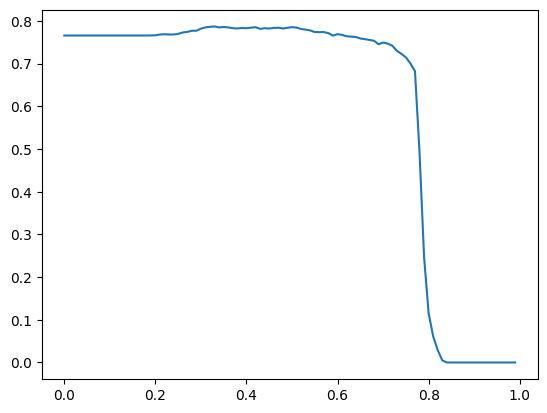

0.33

In [159]:
target = 'TARGET_5Yrs'
balance_method = None
features_selected = ['GP', 'PTS', 'FGM', 'MIN', 'FGA', 'DREB', 'BLK', 'AST']

data_processed = preprocessing(df, balance_method)
X = data_processed[features_selected]
y = data_processed[target]

lr = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('model', SVC(C=1, kernel='rbf', gamma='scale', probability=True))])

result = score_classifier(X, lr, y, verbose=False)
probabilities = lr.predict_proba(X)

thresholds = np.arange(0, 1, 0.01)
scores = []
for threshold in thresholds:
    predictions = probabilities[:, 1] > threshold
    scores.append(f1_score(y, predictions))

plt.plot(thresholds, scores)
plt.show()

thresholds[np.argmax(scores)]

In [160]:
def predict_threshold_svc(model, X, threshold=0.33):
    probabilities = model.predict_proba(X)
    predictions = probabilities[:, 1] > threshold
    return predictions

In [161]:
target = 'TARGET_5Yrs'
balance_method = None

data_processed = preprocessing(df, balance_method)
X = data_processed.drop(target, axis=1)
y = data_processed[target]

lr = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('model', SVC(C=1, kernel='rbf', gamma='scale', probability=True))])

result = score_classifier(X, lr, y, verbose=False, threshold_func=predict_threshold_svc)

result


{'confusion_mat': array([[ 35, 132],
        [ 18, 256]]),
 'recall': 0.9350111519176267,
 'precision': 0.6594274213785293,
 'accuracy': 0.7243921704816673,
 'f1': 0.7729980031025553,
 'classifier': Pipeline(steps=[('scaler', StandardScaler()),
                 ('model', SVC(C=1, probability=True))])}

In [90]:
# save model

import joblib

target = 'TARGET_5Yrs'
balance_method = None
features_selected = ['GP', 'PTS', 'FGM', 'MIN', 'FTA', 'FTM', 'REB', 'OREB', 'FGA']

data_processed = preprocessing(df, balance_method)
X = data_processed[features_selected]
y = data_processed[target]

lr = Pipeline(steps=[('model', LogisticRegression(C=0.1, solver='liblinear'))])
lr.fit(X, y)

joblib.dump(lr, './../models/model_1.pkl')





['./../models/model_1.pkl']

In [91]:
# load model

import joblib

model = joblib.load('./../models/model_1.pkl')

model.predict_proba(X)


array([[0.65859722, 0.34140278],
       [0.661718  , 0.338282  ],
       [0.33962201, 0.66037799],
       ...,
       [0.36262969, 0.63737031],
       [0.50070762, 0.49929238],
       [0.56686131, 0.43313869]])